In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import random
from PIL import Image


In [2]:
dataset_path = Path("/Users/nilufersevdeozdemir/Downloads/chest_xray")

In [3]:
train_normal = dataset_path / "train/NORMAL"
train_pneumonia = dataset_path / "train/PNEUMONIA"

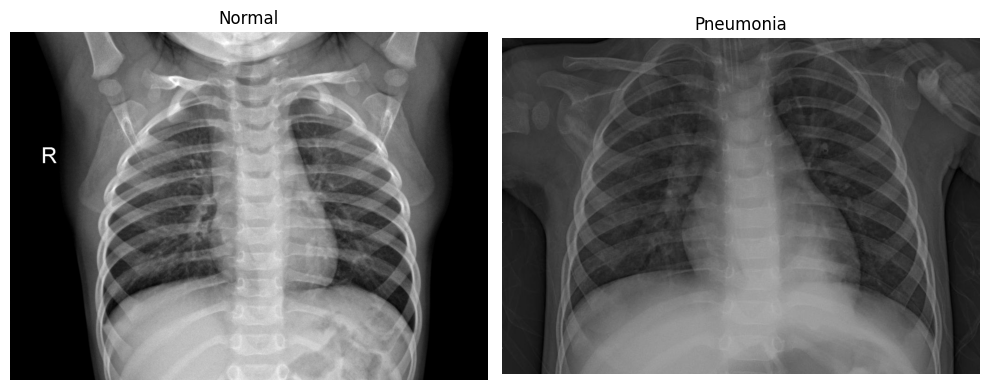

In [17]:
def show_sample_images():
    normal_img = Image.open(random.choice(list(train_normal.glob("*.jpeg"))))
    pneumonia_img = Image.open(random.choice(list(train_pneumonia.glob("*.jpeg"))))
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(normal_img, cmap="gray")
    plt.title("Normal")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pneumonia_img, cmap="gray")
    plt.title("Pneumonia")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

show_sample_images()

In [29]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define preprocessing transforms
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 👈 Convert to 1 channel
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


# Paths 
dataset_path = Path("/Users/nilufersevdeozdemir/Downloads/chest_xray")

# Load datasets
train_dataset = datasets.ImageFolder(dataset_path / 'train', transform=transform)
val_dataset   = datasets.ImageFolder(dataset_path / 'val', transform=transform)
test_dataset  = datasets.ImageFolder(dataset_path / 'test', transform=transform)

# Create data loaders  
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


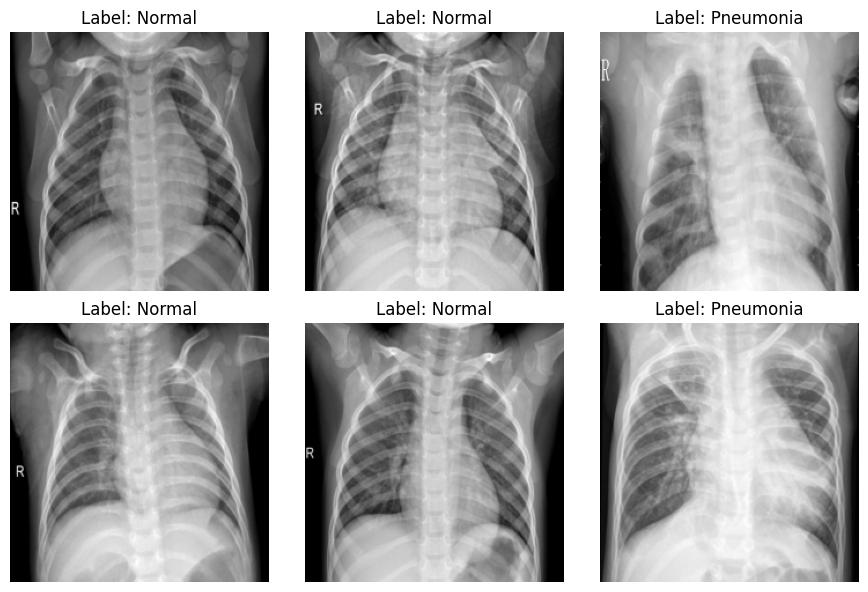

In [30]:
images, labels = next(iter(train_loader))

# Show 6 sample images
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title("Label: " + ("Normal" if labels[i] == 0 else "Pneumonia"))
    ax.axis('off')
plt.tight_layout()
plt.show()



In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

image_size = 224 
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (image_size // 4) * (image_size // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 16, H/2, W/2]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 32, H/4, W/4]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [31]:
model = SimpleCNN(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [32]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.2993
Epoch [2/10], Loss: 0.0929
Epoch [3/10], Loss: 0.0752
Epoch [4/10], Loss: 0.0573
Epoch [5/10], Loss: 0.0454
Epoch [6/10], Loss: 0.0371
Epoch [7/10], Loss: 0.0187
Epoch [8/10], Loss: 0.0145
Epoch [9/10], Loss: 0.0076
Epoch [10/10], Loss: 0.0029


In [34]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels
accuracy, preds, true_labels = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 74.36%


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(true_labels, preds, target_names=test_dataset.classes))

cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


ModuleNotFoundError: No module named 'seaborn'